### Importing the necessary libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

### Importing the dataset

In [2]:
df = pd.read_excel('Text data from Buzz_Jun20.xlsx')

In [3]:
# Looking at the first 3 rows
df.head(3)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Product_Name,Final_Price_after_Discount,Review_Link,Review_Header,Review_Creation_Date,Review_Rating_Score,Review_Text
0,1,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,Excellent fan for an excellent price ...,2018-04-24,5,Excellent fan for an excellent price
1,2,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,I put these fans in my spec houses and everyon...,2019-10-15,5,I put these fans in my spec houses and everyon...
2,3,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,5 Star Review,2019-07-03,5,Rating provided by a verified purchaser


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Rev_id                      1188 non-null   int64         
 1   Retailer                    1188 non-null   object        
 2   Division                    1188 non-null   object        
 3   Category                    1188 non-null   object        
 4   Department                  1188 non-null   object        
 5   Product_URL                 1188 non-null   object        
 6   Brand                       1068 non-null   object        
 7   Product_Name                1188 non-null   object        
 8   Final_Price_after_Discount  1188 non-null   float64       
 9   Review_Link                 1188 non-null   object        
 10  Review_Header               1162 non-null   object        
 11  Review_Creation_Date        1188 non-null   datetime64[n

In [4]:
# Printing out the shape of the dataset and the name of the columns
print("Number of data points in data", df.shape)
print('-'*50)
print("The attributes of data :", df.columns.values)

Number of data points in train data (1188, 14)
--------------------------------------------------
The attributes of data : ['Rev_id' 'Retailer' 'Division' 'Category' 'Department' 'Product_URL'
 'Brand' 'Product_Name' 'Final_Price_after_Discount' 'Review_Link'
 'Review_Header' 'Review_Creation_Date' 'Review_Rating_Score'
 'Review_Text']


# Data Analysis

In [5]:
df.Review_Rating_Score.value_counts()

5    766
4    206
1    101
3     66
2     49
Name: Review_Rating_Score, dtype: int64

We can observe that only 66 reviews out of a total 1188 have a rating of 3 which is around 5% of the total dataset. If we include these points we will have to analyze for the neutral reviews as well which will come at a cost of creating an extra dependent category. Hence, we decide to neglect neutral reviews i.e. rating 3 from our analysis.

In [6]:
# Here, we are filtering our dataset by removing the rows containing the review rating == 3
filtered_reviews=df[(df.Review_Rating_Score != 3)]

In [7]:
# Partitioning the data and giving reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

In [8]:
#changing reviews with score greater than 3 to be positive and vice-versa
actualScore = filtered_reviews['Review_Rating_Score']
positiveNegative = actualScore.map(partition) 
filtered_reviews['Review_Rating_Score'] = positiveNegative
print("Number of data points in our data", filtered_reviews.shape)
filtered_reviews.head(3)

Number of data points in our data (1122, 14)


,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Product_Name,Final_Price_after_Discount,Review_Link,Review_Header,Review_Creation_Date,Review_Rating_Score,Review_Text
0,1,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,Excellent fan for an excellent price ...,2018-04-24,1,Excellent fan for an excellent price
1,2,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,I put these fans in my spec houses and everyon...,2019-10-15,1,I put these fans in my spec houses and everyon...
2,3,Homedepot,Lighting,Ceiling Fans,Ceiling Fans With Lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,Hampton Bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,5 Star Review,2019-07-03,1,Rating provided by a verified purchaser


Now our dataset has 1122 rows and 14 columns

In [9]:
# Since, we have filtered our data, let us reset the index values which will reset index from 0 to 1121
filtered_reviews.reset_index(inplace=True)

In [10]:
# Checking for null values in our dataset
filtered_reviews.isna().sum()

index                           0
Rev_id                          0
Retailer                        0
Division                        0
Category                        0
Department                      0
Product_URL                     0
Brand                         111
Product_Name                    0
Final_Price_after_Discount      0
Review_Link                     0
Review_Header                  24
Review_Creation_Date            0
Review_Rating_Score             0
Review_Text                     0
dtype: int64

We have 111 null values in Brand and 24 null values in Review_Header. Let us replace these null values with 'brand not mentioned' and 'review header not mentioned' respectively.

In [11]:
# replacing na values in Brand with brand not mentioned 
filtered_reviews["Brand"].fillna("brand not mentioned", inplace = True)

In [12]:
# replacing na values in Review_Header with review header not mentioned 
filtered_reviews["Review_Header"].fillna("review header not mentioned", inplace = True)

In [13]:
# Now our dataset do not have any null values
filtered_reviews.isna().sum()

index                         0
Rev_id                        0
Retailer                      0
Division                      0
Category                      0
Department                    0
Product_URL                   0
Brand                         0
Product_Name                  0
Final_Price_after_Discount    0
Review_Link                   0
Review_Header                 0
Review_Creation_Date          0
Review_Rating_Score           0
Review_Text                   0
dtype: int64

In [14]:
# Since we had reset our index, we got an extra index column, let us remove it from out analysis
filtered_reviews=filtered_reviews.drop(columns={'index'})

In [15]:
# The dataset now has 1122 rows and 14 columns
print("Number of data points in our data", filtered_reviews.shape)

Number of data points in our data (1122, 14)


### Donut Plot on the total number of positive and negative reviews

Number of Positive Reviews  972 , ( 86.63101604278076 %)
Number of Negative Reviews  150 , ( 13.368983957219251 %)


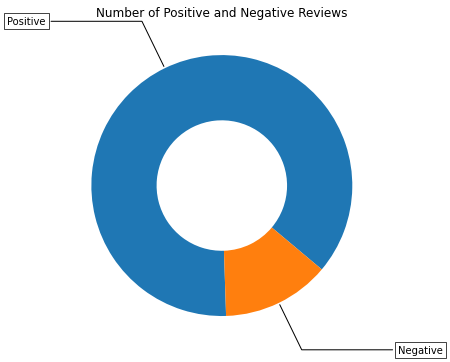

In [16]:
# Code Reference
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = filtered_reviews['Review_Rating_Score'].value_counts()
print("Number of Positive Reviews ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of Negative Reviews ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Positive", "Negative"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of Positive and Negative Reviews")

plt.show()

The number of positive reviews and negative reviews in the dataset are 972 and 150 respectively. This means that the dataset is highly biased towards positive reviews. We will have to take care of this situation during model building.

### Univariate Analysis: Retailer

In [17]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='Review_Rating_Score', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Total Number of Reviews')
    plt.title('% of Positive Reviews')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Negative', 'Positive'))
    plt.show()

In [18]:
def univariate_barplots(data, col1, col2='Review_Rating_Score', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(filtered_reviews.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(filtered_reviews.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(filtered_reviews.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(7))
    print("="*50)

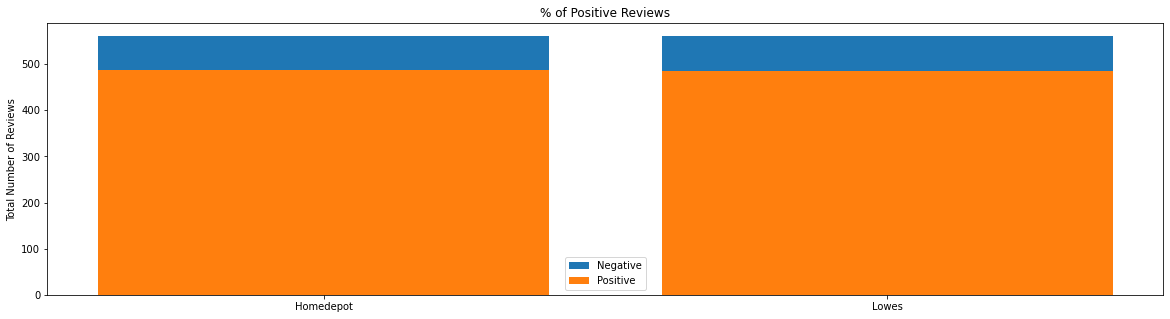

    Retailer  Review_Rating_Score  total       Avg
0  Homedepot                  487    561  0.868093
1      Lowes                  485    561  0.864528


In [19]:
univariate_barplots(filtered_reviews, 'Retailer', 'Review_Rating_Score', False)

### Univariate Analysis: Division

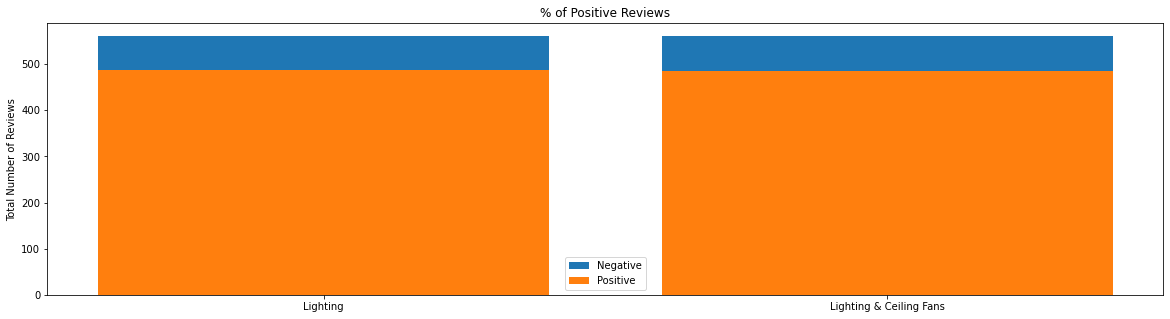

                  Division  Review_Rating_Score  total       Avg
0                 Lighting                  487    561  0.868093
1  Lighting & Ceiling Fans                  485    561  0.864528


In [20]:
univariate_barplots(filtered_reviews, 'Division', 'Review_Rating_Score', False)

### Univariate Analysis: Category

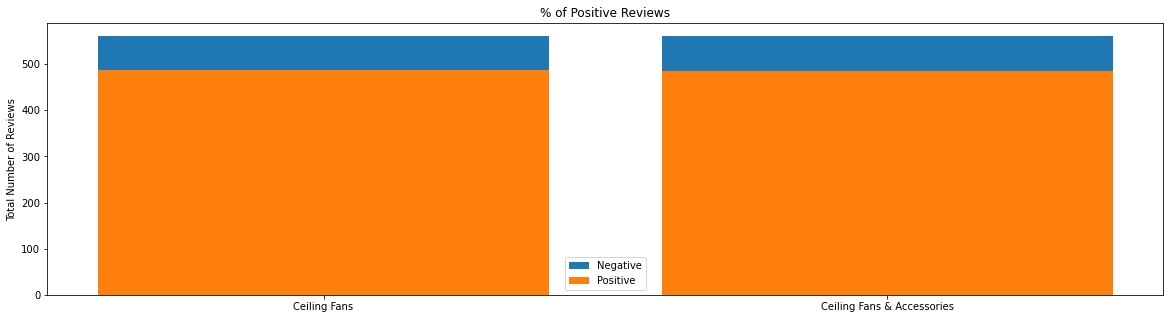

                     Category  Review_Rating_Score  total       Avg
0                Ceiling Fans                  487    561  0.868093
1  Ceiling Fans & Accessories                  485    561  0.864528


In [21]:
univariate_barplots(filtered_reviews, 'Category', 'Review_Rating_Score', False)

### Univariate Analysis: Department

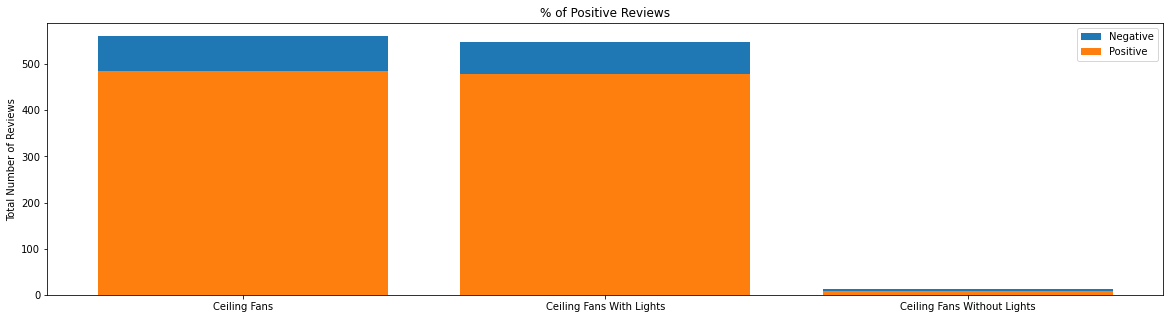

                    Department  Review_Rating_Score  total       Avg
0                 Ceiling Fans                  485    561  0.864528
1     Ceiling Fans With Lights                  478    548  0.872263
2  Ceiling Fans Without Lights                    9     13  0.692308


In [22]:
univariate_barplots(filtered_reviews, 'Department', 'Review_Rating_Score', False)

### Univariate Analysis: Brand

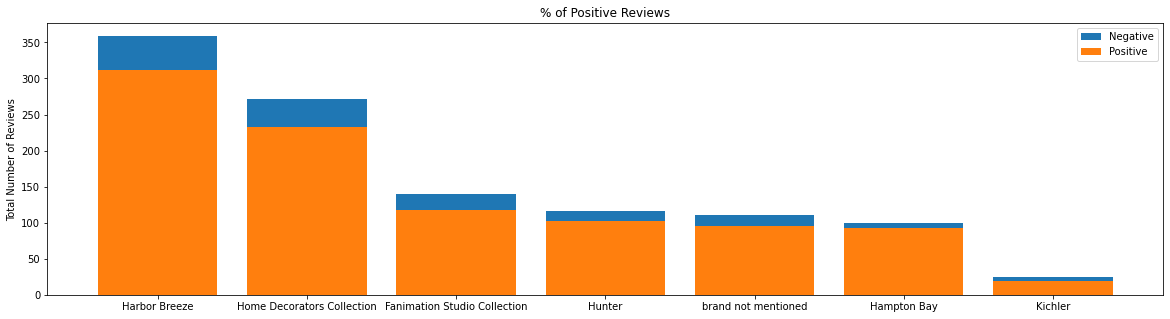

                          Brand  Review_Rating_Score  total       Avg
2                 Harbor Breeze                  312    359  0.869081
3    Home Decorators Collection                  233    272  0.856618
0  Fanimation Studio Collection                  117    140  0.835714
4                        Hunter                  103    116  0.887931
6           brand not mentioned                   95    111  0.855856
1                   Hampton Bay                   93     99  0.939394
5                       Kichler                   19     25  0.760000


In [23]:
univariate_barplots(filtered_reviews, 'Brand', 'Review_Rating_Score', False)

# Text Data Preprocessing

In [24]:
# Replacing the space in Division column with _ and converting the text into lower case
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
filtered_reviews['Division'] = filtered_reviews['Division'].str.replace(' ','_')
filtered_reviews['Division'] = filtered_reviews['Division'].str.lower()
filtered_reviews['Division'].value_counts()

lighting                   561
lighting_&_ceiling_fans    561
Name: Division, dtype: int64

In [25]:
# Replacing the space in Category column with _ and converting the text into lower case
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
filtered_reviews['Category'] = filtered_reviews['Category'].str.replace(' ','_')
filtered_reviews['Category'] = filtered_reviews['Category'].str.lower()
filtered_reviews['Category'].value_counts()

ceiling_fans                  561
ceiling_fans_&_accessories    561
Name: Category, dtype: int64

In [26]:
# Replacing the space in Department column with _ and converting the text into lower case
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
filtered_reviews['Department'] = filtered_reviews['Department'].str.replace(' ','_')
filtered_reviews['Department'] = filtered_reviews['Department'].str.lower()
filtered_reviews['Department'].value_counts()

ceiling_fans                   561
ceiling_fans_with_lights       548
ceiling_fans_without_lights     13
Name: Department, dtype: int64

In [27]:
# Replacing the space in Brand column with _ and converting the text into lower case
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
filtered_reviews['Brand'] = filtered_reviews['Brand'].str.replace(' ','_')
filtered_reviews['Brand'] = filtered_reviews['Brand'].str.lower()
filtered_reviews['Brand'].value_counts()

harbor_breeze                   359
home_decorators_collection      272
fanimation_studio_collection    140
hunter                          116
brand_not_mentioned             111
hampton_bay                      99
kichler                          25
Name: Brand, dtype: int64

In [28]:
# printing some random reviews to have a look at the text in the reviews
sent_0 = filtered_reviews['Review_Text'].values[0]
print(sent_0)
print("="*50)

sent_250 = filtered_reviews['Review_Text'].values[250]
print(sent_250)
print("="*50)

sent_500 = filtered_reviews['Review_Text'].values[500]
print(sent_500)
print("="*50)

sent_1000 = filtered_reviews['Review_Text'].values[1000]
print(sent_1000)
print("="*50)

Excellent fan for an excellent price
It came with my new house purchase but found that it has a very narrow dispersal of light so it doesn't fill our small 15 x 20 living room well. Best suited for a smaller room such as a bedroom or dining room but not a living room... other than that it's a good quality product and I like the remote control that goes with it. Now looking for a decent replacement for my living room to get better lighting :-(
I purchased this fan to go in 5 rooms, my master bedroom, 2 guest bedrooms and my livingroom.  I had them all professionally installed and the only concern is that 2 of the 5 are on the same frequency which means when 1 of the guestrooms can control the fan in my masterbedroom. I'm still trying to figure that part out. I dont have guests that often so I can deal with it while I still try to figure this out.
I purchased this fan on August 20, 2017. Love it but after the first month, I had issues with the fan. I would turn it on via remote and the f

In [29]:
# The below function will expand the contraction of some common english words such as won't, can't etc.. these will be converted
# to will not, can not etc.
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#### Removing the Stopwords

In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [31]:
# Writing function for text preprocessing and combining the above sentences
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

## Preprocessing Review Text

In [32]:
preprocessed_review_text = preprocess_text(filtered_reviews['Review_Text'].values)

100%|████████████████████████████████████████████████████████████████████████████| 1122/1122 [00:00<00:00, 5275.79it/s]


In [33]:
# printing some random reviews
sent_0 = preprocessed_review_text[0]
print(sent_0)
print("="*50)

sent_250 = preprocessed_review_text[250]
print(sent_250)
print("="*50)

sent_500 = preprocessed_review_text[500]
print(sent_500)
print("="*50)

sent_1000 = preprocessed_review_text[1000]
print(sent_1000)
print("="*50)

excellent fan excellent price
came new house purchase found narrow dispersal light not fill small 15 x 20 living room well best suited smaller room bedroom dining room not living room good quality product like remote control goes looking decent replacement living room get better lighting
purchased fan go 5 rooms master bedroom 2 guest bedrooms livingroom professionally installed concern 2 5 frequency means 1 guestrooms control fan masterbedroom still trying figure part dont guests often deal still try figure
purchased fan august 20 2017 love first month issues fan would turn via remote fan would intermittently turn times simply shut would start fan several times finally turned stayed called fanimation told normal calibration purposes less year later fan stopped smelt motor burning needless say fan beautiful definitely air mover works recommend buy fan buy warranty replacement plan lowe friday evening fl summer not get touch manufacturer limited business hours not recommend product not 

## Preprocessing Product Name

In [34]:
# printing some random reviews
sent_0 = filtered_reviews['Product_Name'].values[0]
print(sent_0)
print("="*50)

sent_250 = filtered_reviews['Product_Name'].values[250]
print(sent_250)
print("="*50)

sent_500 = filtered_reviews['Product_Name'].values[500]
print(sent_500)
print("="*50)

sent_1000 = filtered_reviews['Product_Name'].values[1000]
print(sent_1000)
print("="*50)

Rockport 52 in. LED Brushed Nickel Ceiling Fan with Light Kit
Merwry 52 in. Integrated LED Indoor Matte Black Ceiling Fan with Light Kit and Remote Control
Merwry 52 in. Integrated LED Indoor White Ceiling Fan with Light Kit and Remote Control
Fanimation Studio Collection Slinger v2 72-in Matte Black LED Indoor/Outdoor Ceiling Fan with Light Kit and Remote (9-Blade)


In [35]:
preprocessed_product_name = preprocess_text(filtered_reviews['Product_Name'].values)

100%|███████████████████████████████████████████████████████████████████████████| 1122/1122 [00:00<00:00, 14359.37it/s]


In [36]:
# printing some random reviews
sent_0 = preprocessed_product_name[0]
print(sent_0)
print("="*50)

sent_250 = preprocessed_product_name[250]
print(sent_250)
print("="*50)

sent_500 = preprocessed_product_name[500]
print(sent_500)
print("="*50)

sent_1000 = preprocessed_product_name[1000]
print(sent_1000)
print("="*50)

rockport 52 led brushed nickel ceiling fan light kit
merwry 52 integrated led indoor matte black ceiling fan light kit remote control
merwry 52 integrated led indoor white ceiling fan light kit remote control
fanimation studio collection slinger v2 72 matte black led indoor outdoor ceiling fan light kit remote 9 blade


### Preprocessing Review Header

In [37]:
preprocessed_review_header = preprocess_text(filtered_reviews['Review_Header'].values)

100%|███████████████████████████████████████████████████████████████████████████| 1122/1122 [00:00<00:00, 13270.91it/s]


In [38]:
# printing some random reviews
sent_0 = preprocessed_review_header[0]
print(sent_0)
print("="*50)

sent_250 = preprocessed_review_header[250]
print(sent_250)
print("="*50)

sent_500 = preprocessed_review_header[500]
print(sent_500)
print("="*50)

sent_1000 = preprocessed_review_header[1000]
print(sent_1000)
print("="*50)

excellent fan excellent price
came new house purchase found narrow dispersal light
beautiful modern quiet
burned less year


At this stage we have done preprocessing of all the necessary text columns such as review_text, review_header, review_product_name. These are in the form of a list.

In [39]:
filtered_reviews.head(2)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Product_Name,Final_Price_after_Discount,Review_Link,Review_Header,Review_Creation_Date,Review_Rating_Score,Review_Text
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,Excellent fan for an excellent price ...,2018-04-24,1,Excellent fan for an excellent price
1,2,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,I put these fans in my spec houses and everyon...,2019-10-15,1,I put these fans in my spec houses and everyon...


In [40]:
print("Number of data points in our data", filtered_reviews.shape)

Number of data points in our data (1122, 14)


In [41]:
# Storing list containing 'preprocessed_review_text' in the form of a dataframe
preprocessed_review_text = pd.DataFrame({'preprocessed_review_text':preprocessed_review_text})

In [42]:
preprocessed_review_text.head(2)

,preprocessed_review_text
0,excellent fan excellent price
1,put fans spec houses everyone likes like price...


In [43]:
print("Number of data points in our data", preprocessed_review_text.shape)

Number of data points in our data (1122, 1)


In [44]:
# Storing list containing 'preprocessed_product_name' in the form of a dataframe
preprocessed_product_name = pd.DataFrame({'preprocessed_product_name':preprocessed_product_name})

In [45]:
preprocessed_product_name.head(2)

,preprocessed_product_name
0,rockport 52 led brushed nickel ceiling fan lig...
1,rockport 52 led brushed nickel ceiling fan lig...


In [46]:
# Replacing the space in preprocessed_product_name column with _ and converting the text into lower case
preprocessed_product_name['preprocessed_product_name'] = preprocessed_product_name['preprocessed_product_name'].str.replace(' ','_')
preprocessed_product_name['preprocessed_product_name'] = preprocessed_product_name['preprocessed_product_name'].str.lower()
preprocessed_product_name['preprocessed_product_name'].value_counts()

hugger_52_led_indoor_brushed_nickel_ceiling_fan_light_kit                                                                                                             70
harbor_breeze_armitage_52_brushed_nickel_led_indoor_flush_mount_ceiling_fan_light_kit_5_blade                                                                         59
fanimation_studio_collection_slinger_v2_72_matte_black_led_indoor_outdoor_ceiling_fan_light_kit_remote_9_blade                                                        49
fanimation_studio_collection_slinger_v2_72_brushed_nickel_led_indoor_outdoor_commercial_residential_ceiling_fan_light_kit_included_remote_control_included_9_blade    46
harbor_breeze_armitage_52_bronze_led_indoor_flush_mount_ceiling_fan_light_kit_5_blade                                                                                 36
                                                                                                                                                           

In [47]:
print("Number of data points in our data", preprocessed_product_name.shape)

Number of data points in our data (1122, 1)


In [48]:
# Storing list containing 'preprocessed_review_header' in the form of a dataframe
preprocessed_review_header = pd.DataFrame({'preprocessed_review_header':preprocessed_review_header})

In [49]:
preprocessed_review_header.head(2)

,preprocessed_review_header
0,excellent fan excellent price
1,put fans spec houses everyone


In [50]:
print("Number of data points in our data", preprocessed_review_header.shape)

Number of data points in our data (1122, 1)


In [51]:
# Merging these new columns in our original dataset i.e. filtered_reviews
merge1=pd.merge(filtered_reviews, preprocessed_review_text, left_index=True, right_index=True)

In [52]:
merge2=pd.merge(merge1, preprocessed_product_name, left_index=True, right_index=True)

In [53]:
# Creating a dataframe preprocessed_data to containing all the merged columns
preprocessed_data=pd.merge(merge2, preprocessed_review_header, left_index=True, right_index=True)

In [54]:
preprocessed_data.head()

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Product_Name,Final_Price_after_Discount,Review_Link,Review_Header,Review_Creation_Date,Review_Rating_Score,Review_Text,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,Excellent fan for an excellent price ...,2018-04-24,1,Excellent fan for an excellent price,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price
1,2,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,I put these fans in my spec houses and everyon...,2019-10-15,1,I put these fans in my spec houses and everyon...,put fans spec houses everyone likes like price...,rockport_52_led_brushed_nickel_ceiling_fan_lig...,put fans spec houses everyone
2,3,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,5 Star Review,2019-07-03,1,Rating provided by a verified purchaser,rating provided verified purchaser,rockport_52_led_brushed_nickel_ceiling_fan_lig...,5 star review
3,4,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,"Easy to put together, our 3rd purchase for th...",2019-01-17,1,"Easy to put together, our 3rd purchase for th...",easy put together 3rd purchase brand 3 rooms f...,rockport_52_led_brushed_nickel_ceiling_fan_lig...,easy put together 3rd purchase
4,5,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,Rockport 52 in. LED Brushed Nickel Ceiling Fan...,69.97,https://www.homedepot.com/ReviewServices/revie...,This fan it was easily to install and it is...,2019-02-09,1,This fan it was easily to install and it is a ...,fan easily install beautiful model,rockport_52_led_brushed_nickel_ceiling_fan_lig...,fan easily install


In [55]:
# From the preprocessed_data table we will drop the columns which will not be requeired in the further analysis
preprocessed_data=preprocessed_data.drop(columns={'Review_Header','Review_Text','Product_Name'})

In [56]:
preprocessed_data.head(5)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price
1,2,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-10-15,1,put fans spec houses everyone likes like price...,rockport_52_led_brushed_nickel_ceiling_fan_lig...,put fans spec houses everyone
2,3,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-07-03,1,rating provided verified purchaser,rockport_52_led_brushed_nickel_ceiling_fan_lig...,5 star review
3,4,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-01-17,1,easy put together 3rd purchase brand 3 rooms f...,rockport_52_led_brushed_nickel_ceiling_fan_lig...,easy put together 3rd purchase
4,5,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-02-09,1,fan easily install beautiful model,rockport_52_led_brushed_nickel_ceiling_fan_lig...,fan easily install


In [57]:
preprocessed_data.shape

(1122, 14)

Our final dataset contains 1122 rows and 14 columns. We will save this dataframe in the form of a csv file which can be used in further analysis.

In [58]:
# Saving the preprocessed data into a csv file
preprocessed_data.to_csv('preprocessed_data.csv')